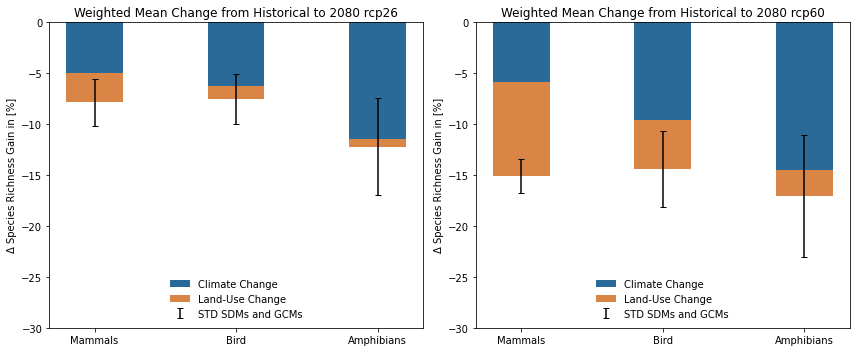

In [35]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
             # Calculate the difference
                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa
                loss_mask = difference < 0
                non_zero_mask = newvalue_hist_sum_taxa != 0
                climate_change = xr.where(loss_mask & non_zero_mask, difference / newvalue_hist_sum_taxa * 100, 0)

                difference = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa
                loss_mask = difference < 0
                non_zero_mask = sum_bin_hist_sum_taxa != 0
                climate_land_change = xr.where(loss_mask & non_zero_mask, difference / sum_bin_hist_sum_taxa * 100, 0)



                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0)
                climate_change_loss = climate_change.where(climate_change < 0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=0, bottom=-30)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


In [ ]:
                min_threshold = 1e-10
 
                #newvalue_hist_sum_taxa = newvalue_hist_sum_taxa.round(decimals=6)
                newvalue_hist_sum_taxa = np.log(newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > 0))

                #newvalue_future_sum_taxa = newvalue_future_sum_taxa.round(decimals=6)
                newvalue_future_sum_taxa = np.log(newvalue_future_sum_taxa.where(newvalue_future_sum_taxa > 0))

                #sum_bin_hist_sum_taxa = sum_bin_hist_sum_taxa.where(newvalue_hist_sum_taxa >= min_threshold, np.nan)
                sum_bin_hist_sum_taxa = np.log(sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > 0))
                
                #sum_bin_future_sum_taxa = sum_bin_future_sum_taxa.where(newvalue_hist_sum_taxa >= min_threshold, np.nan)
                sum_bin_future_sum_taxa = np.log(sum_bin_future_sum_taxa.where(sum_bin_future_sum_taxa > 0))

                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa

                                # Identify where there is a loss (future < historical)
                # Round the values
                newvalue_future_sum_taxa = newvalue_future_sum_taxa.round(decimals=10)

                # Recalculate the difference
                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa

                # Reapply the masks
                loss_mask = difference > 0
                non_zero_mask = newvalue_hist_sum_taxa != 0

                # Recalculate the relative change with a minimum threshold
                max_relative_change=100
                climate_change = xr.where(loss_mask & non_zero_mask, difference / newvalue_hist_sum_taxa * 100, 0)
                climate_change = climate_change.where(climate_change <= max_relative_change, max_relative_change)
                
                
                                
                                # Calculate the difference
                difference = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference > 0
                sum_bin_hist_sum_taxa = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa >= min_threshold, np.nan)
                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = sum_bin_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_land_change = xr.where(loss_mask & non_zero_mask, difference / sum_bin_hist_sum_taxa * 100, 0)
# Apply log transformation only to positive values

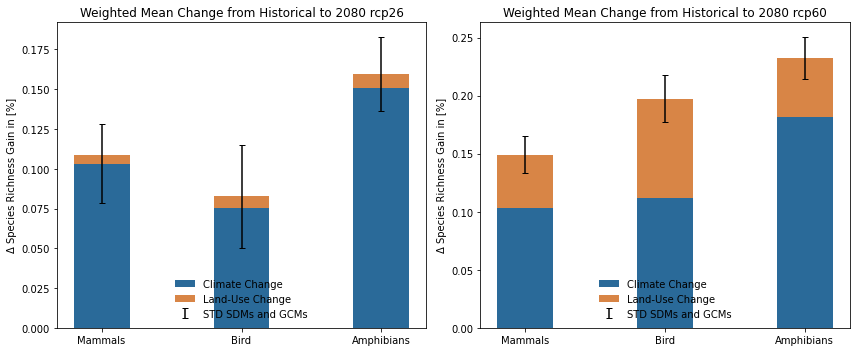

In [21]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue


                min_threshold = 1e-6  # Adjust this threshold based on your data


                newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)
                difference = np.divide(
                    newvalue_future_sum_taxa - newvalue_hist_sum_taxa_filtered,
                    newvalue_hist_sum_taxa_filtered,
                    where=newvalue_hist_sum_taxa_filtered > min_threshold
                )
                climate_change = difference.where((np.abs(difference) <= 1) & np.isfinite(difference))

                sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
                difference = np.divide(
                    sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa_filtered,
                    sum_bin_hist_sum_taxa_filtered,
                    where=newvalue_hist_sum_taxa_filtered > min_threshold
                )
                climate_land_change = difference.where((np.abs(difference) <= 1) & np.isfinite(difference)) 
                
                
                climate_change_loss = climate_change.where(climate_change > 0)
                climate_land_change_loss = climate_land_change.where(climate_land_change>0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    #ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


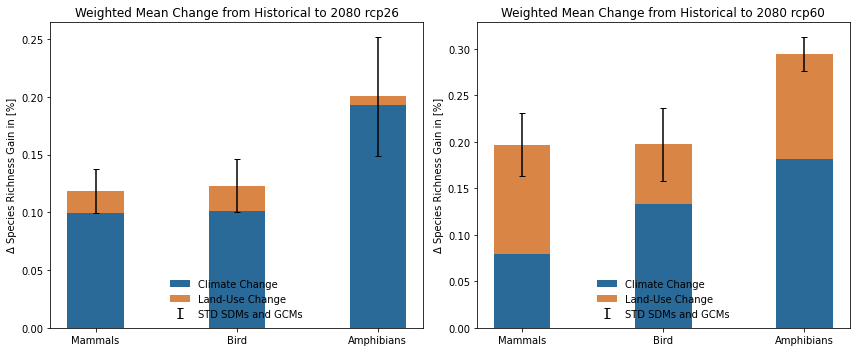

In [20]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue


                min_threshold = 1e-6  # Adjust this threshold based on your data


                newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)
                difference = np.divide(
                    newvalue_future_sum_taxa - newvalue_hist_sum_taxa_filtered,
                    newvalue_hist_sum_taxa_filtered,
                    where=newvalue_hist_sum_taxa_filtered > min_threshold
                )
                climate_change = difference.where((np.abs(difference) <= 1) & np.isfinite(difference))
              #  climate_change= climate_change * 100
                
                
                sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
                difference = np.divide(
                    sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa_filtered,
                    sum_bin_hist_sum_taxa_filtered,
                    where=newvalue_hist_sum_taxa_filtered > min_threshold
                )
                climate_land_change = difference.where((np.abs(difference) <= 1) & np.isfinite(difference)) 
                
               # climate_land_change= climate_land_change * 100     
                climate_change_loss = climate_change.where(climate_change > 0)
                climate_land_change_loss = climate_land_change.where(climate_land_change>0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    #ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


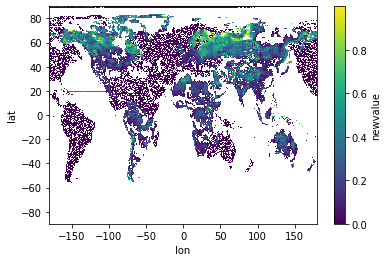

In [19]:
final_weighted_mean_newvalue_change[scenario][taxa].plot()

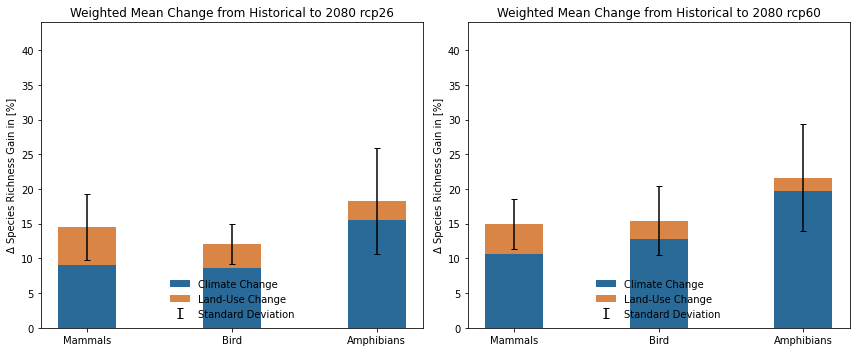

In [63]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM","GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue


                min_threshold = 1e-6  # Adjust this threshold based on your data


                newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)
                difference = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa_filtered) / newvalue_hist_sum_taxa_filtered * 100
                climate_change = difference.where((difference >= -100) & (difference <= 100))
                
                climate_change = climate_change.where(non_zero_mask, np.nan)

                
                sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
                difference = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa_filtered) / sum_bin_hist_sum_taxa_filtered * 100
                climate_land_change = difference.where((difference >= -100) & (difference <= 100))


                climate_land_change = climate_land_change.where(non_zero_mask, np.nan)

                
               # climate_land_change= climate_land_change * 100     
                climate_change_loss = climate_change.where(climate_change > 0)
                climate_land_change_loss = climate_land_change.where(climate_land_change>0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Standard Deviation')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'Standard Deviation'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


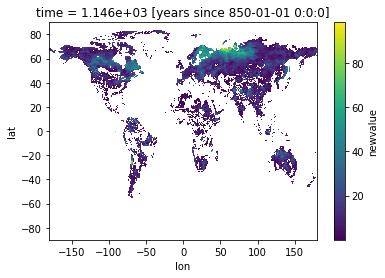

In [61]:
mean_newvalue_change[scenario][taxa][sdm][gcm].plot()

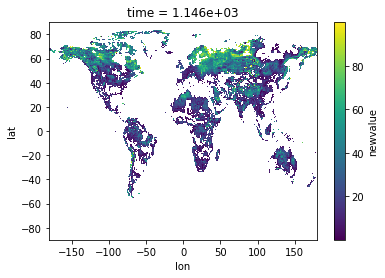

In [54]:
final_weighted_mean_newvalue_change[scenario][taxa].plot()

In [43]:
# Assuming you have identified that values should be masked out for a certain lat range
lat_min, lat_max = -30, 30  # Define the latitude range that should be ocean
lon_min, lon_max = -180, 180  # Define the longitude range if needed

# Mask out values in the specified lat range (and optionally lon range)
newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa_filtered.where(
    ~((newvalue_hist_sum_taxa_filtered.lat >= lat_min) & 
      (newvalue_hist_sum_taxa_filtered.lat <= lat_max) &
      (newvalue_hist_sum_taxa_filtered.lon >= lon_min) & 
      (newvalue_hist_sum_taxa_filtered.lon <= lon_max)),
    np.nan
)


# Now proceed with your calculations as before


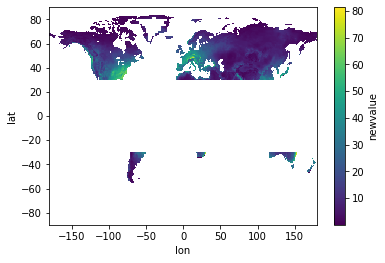

In [44]:
newvalue_hist_sum_taxa_filtered.plot()

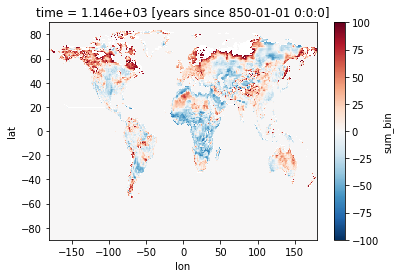

In [25]:

sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
difference = np.divide(
    sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa_filtered,
    sum_bin_hist_sum_taxa_filtered,
    where=newvalue_hist_sum_taxa_filtered > min_threshold
)
climate_land_change = difference.where((np.abs(difference) <= 1) & np.isfinite(difference)) 

test = climate_land_change * 100     

test.plot()

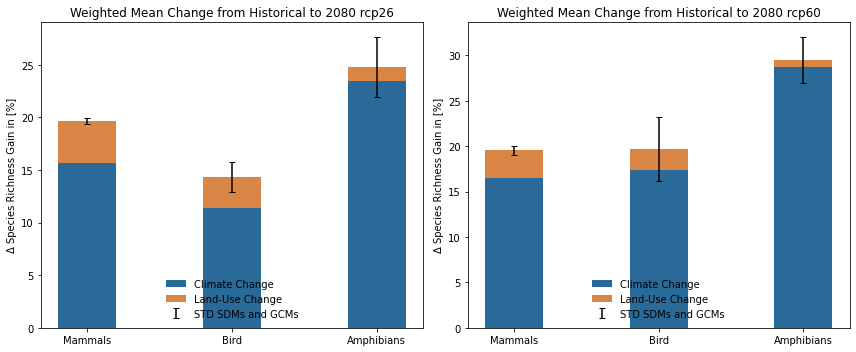

In [18]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue


                min_threshold = 1e-6  # Adjust this threshold based on your data

                # Replace values below the threshold with NaN to avoid division by very small numbers
                newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)

                # Calculate the relative difference as a percentage
                difference = (newvalue_future_sum_taxa - newvalue_hist_sum_taxa_filtered) / newvalue_hist_sum_taxa_filtered * 100

                # After calculating the percentage differences, filter out extreme values
                # Here you may want to decide on a sensible maximum percentage change based on your data's context
                max_relative_change = 100  # Example threshold, adjust as needed
                climate_change = difference.where((difference <= max_relative_change) & (difference >= -max_relative_change), np.nan)

                # Repeat the process for the land use change data
                sum_bin_hist_sum_taxa_filtered = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > min_threshold, np.nan)
                difference_land = (sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa_filtered) / sum_bin_hist_sum_taxa_filtered * 100

                # Filter out extreme values for land use change as well
                climate_land_change = difference_land.where((difference_land <= max_relative_change) & (difference_land >= -max_relative_change), np.nan)

                
                
                climate_change_loss = climate_change.where(climate_change > 0)
                climate_land_change_loss = climate_land_change.where(climate_land_change>0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    #ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


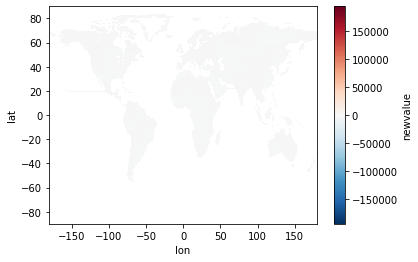

In [19]:
difference.plot()

In [77]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    

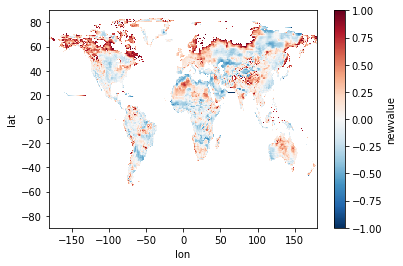

In [78]:
# Set a minimum threshold to avoid division by very small numbers
min_threshold = 1e-6  # Adjust this threshold based on your data

# Replace values below the threshold with NaN to avoid division by very small numbers
newvalue_hist_sum_taxa_filtered = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa > min_threshold, np.nan)

# Perform the relative difference calculation with the filtered data
test = np.divide(
    newvalue_future_sum_taxa - newvalue_hist_sum_taxa_filtered,
    newvalue_hist_sum_taxa_filtered,
    where=newvalue_hist_sum_taxa_filtered > min_threshold
)

# Mask out infinite or NaN values that arise from division by zero or near-zero values
test = test.where((np.abs(test) <= 1) & np.isfinite(test))

# Plot the result
test.plot()


In [13]:
difference.mean()

<xarray.DataArray 'sum_bin' ()>
array(0.16286546)
Coordinates:
    time     float64 1.146e+03

In [69]:
rel = test/newvalue_hist_sum_taxa

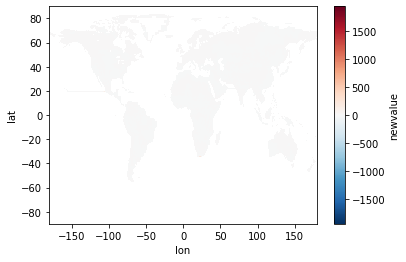

In [70]:
rel.plot()

In [55]:
newvalue_hist_sum_taxa = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa != 0, np.nan)
newvalue_future_sum_taxa = newvalue_future_sum_taxa.where(newvalue_future_sum_taxa != 0, np.nan)
sum_bin_hist_sum_taxa = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa != 0, np.nan)
sum_bin_future_sum_taxa = sum_bin_future_sum_taxa.where(sum_bin_future_sum_taxa != 0, np.nan)

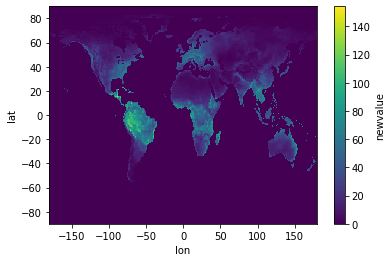

In [ ]:
newvalue_future_sum_taxa.plot()

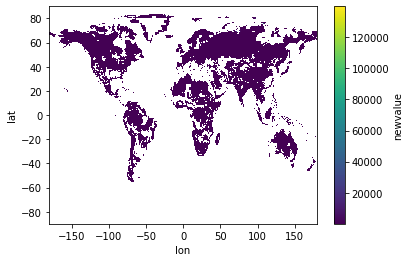

In [26]:
test= gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"]).plot()

In [ ]:
# Apply log transformation only to positive values
sum_bin_hist_sum_taxa_log = np.log(sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa > 0))
sum_bin_future_sum_taxa_log = np.log(sum_bin_future_sum_taxa.where(sum_bin_future_sum_taxa > 0))

# Calculate the difference on the log scale
difference_log_land = sum_bin_future_sum_taxa_log - sum_bin_hist_sum_taxa_log

# Identify where there is a loss (future < historical) on the log scale
loss_mask_log_land = difference_log_land > 0

# Calculate relative change on the log scale, transforming back to the original scale if needed
relative_change_land = np.exp(difference_log_land) - 1  # This gives you the multiplicative change
relative_change_percentage_land = relative_change_land * 100  # Convert to percentage
relative_change_percentage_land = relative_change_percentage_land.where(relative_change_percentage_land <= max_relative_change, max_relative_change)

# Mask out extreme changes if necessary
climate_land_change_loss = relative_change_percentage_land.where(relative_change_percentage_land > 0)


In [ ]:
#try log 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM","GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
             # Calculate the difference

                
                min_threshold = 1e-6
 

                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa

                                # Identify where there is a loss (future < historical)
                # Round the values
              #  newvalue_future_sum_taxa = newvalue_future_sum_taxa.round(decimals=10)

                # Recalculate the difference
                min_threshold = 1e-6
                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa
                loss_mask = difference > 0
                sum_bin_hist_sum_taxa = sum_bin_hist_sum_taxa.where(sum_bin_hist_sum_taxa >= min_threshold, np.nan)
                non_zero_mask = newvalue_hist_sum_taxa != 0
                max_relative_change=100
                climate_change = xr.where(loss_mask & non_zero_mask, difference / newvalue_hist_sum_taxa * 100, 0)
                climate_change = climate_change.where(climate_change <= max_relative_change, max_relative_change)
                
                
                                
                                # Calculate the difference
                difference = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference > 0
                newvalue_hist_sum_taxa = newvalue_hist_sum_taxa.where(newvalue_hist_sum_taxa >= min_threshold, np.nan)
                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = sum_bin_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_land_change = xr.where(loss_mask & non_zero_mask, difference / sum_bin_hist_sum_taxa * 100, 0)
                climate_land_change = climate_land_change.where(climate_land_change <= max_relative_change, max_relative_change)
# Apply log transformation only to positive values

                                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change>0)
                climate_change_loss = climate_change.where(climate_change > 0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


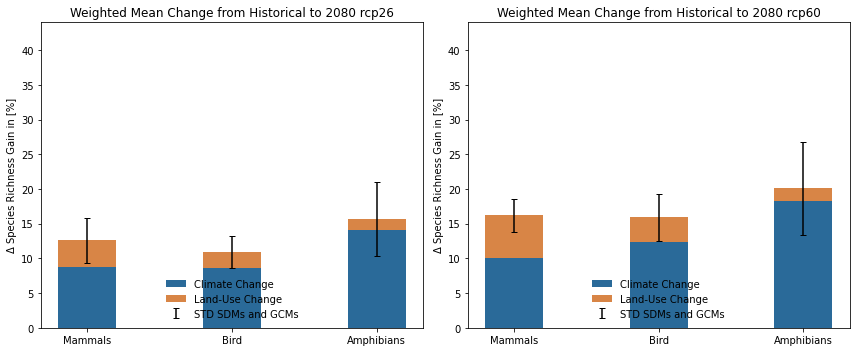

In [71]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM","GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
             # Calculate the difference

                
                da1_filled = newvalue_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = newvalue_hist_sum_taxa.fillna(0)  # Replace NaNs with 0
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))
                climate_change = relative_difference.fillna(0) * 100 # Replace NaNs from division by zero with 0
                
                
                # Handle missing values (if necessary)
                da1_filled = sum_bin_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = sum_bin_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_land_change = relative_difference.fillna(0) * 100  # Replace NaNs from division by zero with 0



                                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change>0)
                climate_change_loss = climate_change.where(climate_change > 0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


In [62]:
climate_change.max()

<xarray.DataArray 'newvalue' ()>
array(100.)

In [63]:
climate_land_change.max()

<xarray.DataArray 'sum_bin' ()>
array(100.)
Coordinates:
    time     float64 1.146e+03

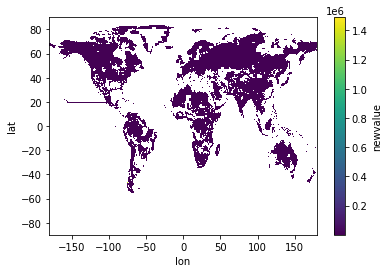

In [193]:
sdm_data_newvalue[0].plot()

In [143]:
# Assuming you have a land-sea mask, where ocean cells are False

# Load the land use dataset
da_landuse = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126.nc", decode_times=False)
# Get the time values

da_landuse = da_landuse.isel(time=1)
land_sea_mask = ~np.isnan(mean_newvalue_change[scenario][taxa]["GBM"][gcm])

data_array_corrected = sdm_data_newvalue[0].where(loss_mask)


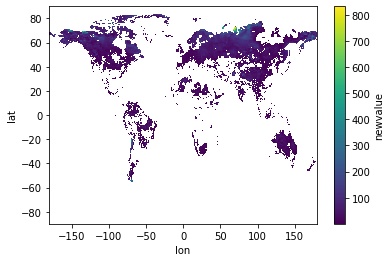

In [145]:
data_array_corrected.plot()

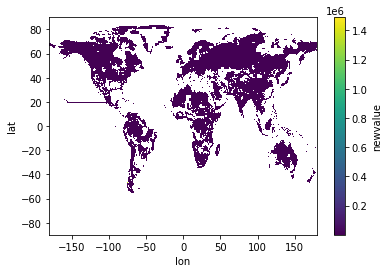

In [99]:
                    ncfname = LandUseList
                    da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                    da_landuse = da_landuse.isel(time=time)

In [34]:
test = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])

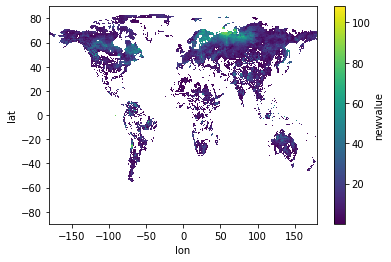

In [91]:
mean_newvalue_change[scenario][taxa]["GBM"][gcm].plot()

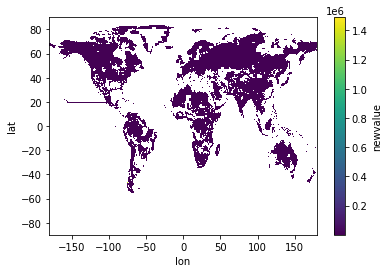

In [97]:
weighted_mean_newvalue_change[scenario][taxa]["GAM"].plot()

In [38]:
test2=sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])

In [68]:
unl = sdm_data_newvalue[:1]

In [74]:
for i, data_array in enumerate(sdm_data_newvalue):
    print(f"DataArray {i} non-NaN count: {data_array.count().values}")


DataArray 0 non-NaN count: 47823
DataArray 1 non-NaN count: 51609


In [79]:
lower_bound = -100
upper_bound = 100
for i, data_array in enumerate(sdm_data_newvalue):
    out_of_bounds = ((data_array > upper_bound) | (data_array < lower_bound)).sum()
    print(f"DataArray {i} out-of-bounds count: {out_of_bounds.values}")


DataArray 0 out-of-bounds count: 4968
DataArray 1 out-of-bounds count: 0


In [86]:
extreme_values = sdm_data_newvalue[0].where((sdm_data_newvalue[0] > upper_bound) | (sdm_data_newvalue[0] < lower_bound), drop=True)
print(extreme_values)


<xarray.DataArray 'newvalue' (lat: 157, lon: 582)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 83.75 83.25 82.75 82.25 ... -54.75 -55.25 -55.75


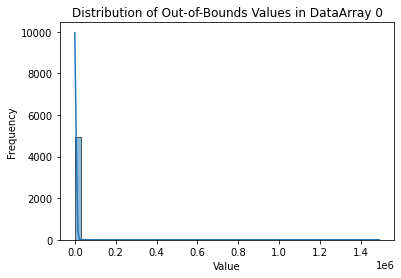

In [87]:
import seaborn as sns

# Flatten the array and convert to a numpy array for plotting
extreme_values_flat = extreme_values.values.flatten()
extreme_values_flat = extreme_values_flat[~np.isnan(extreme_values_flat)]  # Remove NaN values for plotting

sns.histplot(extreme_values_flat, bins=50, kde=True)
plt.title('Distribution of Out-of-Bounds Values in DataArray 0')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


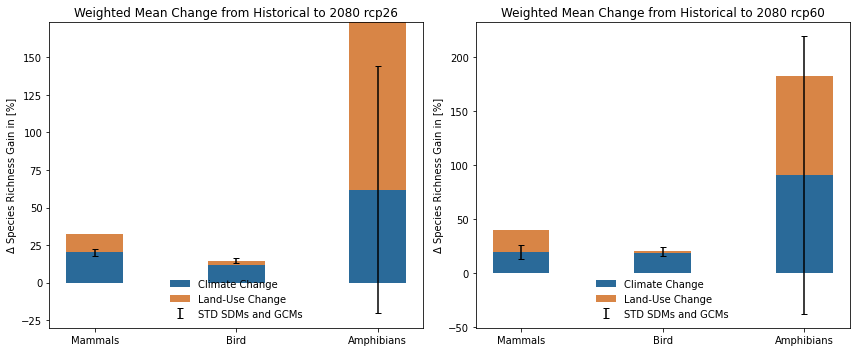

In [48]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants




# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = [ "GAM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)
                    
                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
             # Calculate the difference
                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa

                # Identify where there is a loss (future < historical)
 
                                # Repeat similar steps for sum_bin data
                gain_mask = difference > 0.001
                non_zero_mask = newvalue_hist_sum_taxa != 0
                climate_change = xr.where(gain_mask & non_zero_mask, difference / newvalue_hist_sum_taxa * 100, 0)



                
                                # Calculate the difference
                difference = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa

                # Similar steps for sum_bin data
                gain_mask = sum_bin_future_sum_taxa > 0.001
                non_zero_mask = sum_bin_hist_sum_taxa != 0
                climate_land_change = xr.where(gain_mask & non_zero_mask, difference / sum_bin_hist_sum_taxa * 100, 0)

                # Handle NaN values or very small values as needed
                climate_land_change_gain = climate_land_change.where(climate_land_change > 0.001)
                climate_change_gain = climate_change.where(climate_change > 0.001)





                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_gain
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_gain
                
                gcm_data_newvalue.append(climate_change_gain)
                gcm_data_sum_bin.append(climate_land_change_gain)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []
for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][taxa][sdm][gcm]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    #ax.set_ylim(top=0, bottom=-30)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()
